### IVA intra grupo y extra grupo en comunidades de grupos economicos

En este notebook se calcula el flujo intra y extragrupo en cada una de los grupos economicos definidos, asi como otras metricas asociadas.

### Iniciar sesion en spark

In [44]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
import pyspark
import pandas as pd
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
from pyspark.sql.types import StringType,TimestampType


In [45]:
spark = SparkSession.builder \
  .appName("Test")  \
  .config("spark.yarn.access.hadoopFileSystems","abfs://data@datalakesii.dfs.core.windows.net/") \
  .config("spark.executor.memory", "16g") \
  .config("spark.driver.memory", "12g")\
  .config("spark.executor.cores", "2") \
  .config("spark.driver.maxResultSize", "12g") \
  .getOrCreate()

warnings.filterwarnings('ignore', category=DeprecationWarning)
sc=spark.sparkContext
sc.setLogLevel ('ERROR')
spark.conf.set("spark.sql.parquet.int96RebaseModeInRead", "CORRECTED")



### Datos de grupos economicos

In [46]:
spark.read.parquet("abfs://data@datalakesii.dfs.core.windows.net/DatosOrigen/LibSDF/GE_APIUX_ARFI_E").createOrReplaceTempView("grupos")
spark.sql('select PARU_RUT_E,COM, count(*) as c from grupos group by PARU_RUT_E, COM order by PARU_RUT_E asc').createOrReplaceTempView("grupos")
spark.sql('select PARU_RUT_E as CONT_RUT,COM from grupos  order by PARU_RUT_E asc').createOrReplaceTempView("grupos")
spark.sql('select * from grupos').show()

+--------------------+----+
|            CONT_RUT| COM|
+--------------------+----+
|+++4/3jzUwtDPSSo3...| 460|
|++7yFnLR2jk0Wr0e8...|2478|
|++WLg1DbuZQ0MUQEN...|2915|
|++YxswwB51l+3P6mO...|1799|
|++ggVpHHILx+9SGu8...|1141|
|++qoXOhoawzvRog9E...| 999|
|+/+yqr5XeK0rOoKkG...|3114|
|+/HrCRshGy4wSSO1V...| 126|
|+/JZf0TTOGVxNx9tj...| 325|
|+/R7TO3QchPVrRHn9...|1091|
|+/bsZuw7/ADsTou53...|2202|
|+/cJ7EBd5oKjQfhxu...|1018|
|+0dURcPCBYLGVKmIt...| 614|
|+0f/GM34xojh+tn7A...| 321|
|+0ut+stCHqH6UHSAh...|2659|
|+0yKx5GSw/Q5FoSrp...|1157|
|+1FNxAxXZVPFSdmBl...|1920|
|+1YKE5LQO+CE2nB6H...| 595|
|+1eDEaPXcR4UTQlQz...|1329|
|+1iuDsJuEu9oPjZFA...| 330|
+--------------------+----+
only showing top 20 rows



### Informacion de los arcos comerciales 

In [47]:
spark.read.parquet("abfs://data@datalakesii.dfs.core.windows.net/DatosOrigen/LibSDF/JBA_ARCOS_E").createOrReplaceTempView("arcos")
spark.sql('select PARU_RUT_E0 as emisor, PARU_RUT_E2 as receptor, Monto_iva from arcos where Monto_iva>0').createOrReplaceTempView("arcos")


### Cruce de grupos economicos con emisor y receptor del arco

In [48]:
spark.sql('select emisor,grupos.COM as comunidad_emisor, receptor, Monto_IVA from arcos left join grupos on arcos.emisor=grupos.CONT_RUT').createOrReplaceTempView('arcos')
spark.sql('select  emisor,comunidad_emisor,receptor,grupos.COM as comunidad_receptor, Monto_IVA from arcos left join grupos on arcos.receptor=grupos.CONT_RUT').createOrReplaceTempView('arcos')
spark.sql('select * from arcos where comunidad_emisor is not null or comunidad_receptor is not null').createOrReplaceTempView('arcos')
spark.sql('select * from arcos').show()


+--------------------+----------------+--------------------+------------------+---------+
|              emisor|comunidad_emisor|            receptor|comunidad_receptor|Monto_IVA|
+--------------------+----------------+--------------------+------------------+---------+
|+++4/3jzUwtDPSSo3...|             460|ABszgMcSyeqDOADH3...|              null|   483588|
|+++4/3jzUwtDPSSo3...|             460|B69egPvHdCLmFLUn9...|              null|   622820|
|+++4/3jzUwtDPSSo3...|             460|DN7mjSZwbbnmYguun...|              null|  1689480|
|+++4/3jzUwtDPSSo3...|             460|KvIab/RtzKITBfm6x...|              null|   443916|
|+++4/3jzUwtDPSSo3...|             460|QaLiEyp5aXzy/2NE/...|              null|  5441904|
|+++4/3jzUwtDPSSo3...|             460|RoW0pFG+GHdTz7TIL...|              null|   626240|
|+++4/3jzUwtDPSSo3...|             460|awn1vGJ0+HsBiLukr...|              null|   848768|
|+++4/3jzUwtDPSSo3...|             460|fROwi9OYoxMmHbnfF...|              null|   174800|
|+++4/3jzU

### Emision extra grupo e intra grupo

In [49]:
spark.sql('select comunidad_emisor as comunidad, sum(Monto_IVA) as emision_intragrupo from arcos where comunidad_emisor=comunidad_receptor and comunidad_emisor is not null group by comunidad_emisor order by comunidad_emisor asc').createOrReplaceTempView('emision_intra')
spark.sql('select comunidad_emisor as comunidad, sum(Monto_IVA) as emision_extragrupo from arcos where comunidad_emisor<>comunidad_receptor and comunidad_emisor is not null group by comunidad_emisor order by comunidad_emisor asc').createOrReplaceTempView('emision_extra')

### Recepcion extra grupo e intra grupo

In [50]:
spark.sql('select comunidad_receptor as comunidad, sum(Monto_IVA) as recepcion_intragrupo from arcos where comunidad_emisor=comunidad_receptor and comunidad_receptor is not null group by comunidad_receptor order by comunidad_receptor asc').createOrReplaceTempView('recepcion_intra')
spark.sql('select comunidad_receptor as comunidad, sum(Monto_IVA) as recepcion_extragrupo from arcos where comunidad_emisor<>comunidad_receptor and comunidad_receptor is not null group by comunidad_receptor order by comunidad_receptor asc').createOrReplaceTempView('recepcion_extra')

### Union de tablas

In [51]:
spark.sql('select case when emision_intra.comunidad is null then emision_extra.comunidad else emision_intra.comunidad end as com, emision_intragrupo, emision_extragrupo from emision_intra full outer join emision_extra on emision_extra.comunidad=emision_intra.comunidad').createOrReplaceTempView('emision')
spark.sql('select case when recepcion_intra.comunidad is null then recepcion_extra.comunidad else recepcion_intra.comunidad end as com, recepcion_intragrupo, recepcion_extragrupo from recepcion_intra full outer join recepcion_extra on recepcion_extra.comunidad=recepcion_intra.comunidad order by recepcion_intra.comunidad asc').createOrReplaceTempView('recepcion')

In [52]:
aux=spark.sql('select case when emision.com is null then recepcion.com else emision.com end as com, emision_intragrupo, emision_extragrupo,  recepcion_intragrupo, recepcion_extragrupo from emision full outer join recepcion on emision.com=recepcion.com')
aux.createOrReplaceTempView('iva_comunidad')

### Calculo de KPI's adicionales

Se agregan lo siguientes indicadores que ayudan a identificar el flujo de IVA desde y hacia estos grupos:
- Porcentaje de emision extra grupo
- Porcentaje de recepcion extra grupo
- Tasa de emision intra/extra grupo

In [53]:
spark.sql('select com, recepcion_extragrupo/(recepcion_intragrupo+recepcion_extragrupo)*100 as perct_recepcion_extra, recepcion_extragrupo,emision_extragrupo/(emision_intragrupo+emision_extragrupo)*100 as perct_emision_extra,emision_intragrupo,emision_extragrupo,emision_intragrupo/emision_extragrupo as tasa_emision_intra_extra from iva_comunidad').createOrReplaceTempView('iva_comunidad')

Se agrega tambien el tamanio de la comunidad

In [54]:
spark.sql('select COM as grupo ,count(*) as n_contribuyentes from grupos group by COM').createOrReplaceTempView('comunidad')
spark.sql('select * from comunidad left join iva_comunidad on comunidad.grupo=iva_comunidad.COM').createOrReplaceTempView('iva_comunidad')

### Datos procesados y ordenados descendentemente por tasa de emision intra/extra grupo

In [55]:
df=spark.sql('select grupo, n_contribuyentes,perct_recepcion_extra,recepcion_extragrupo, perct_emision_extra, emision_intragrupo, emision_extragrupo, tasa_emision_intra_extra from iva_comunidad order by tasa_emision_intra_extra desc').toPandas()
df.head(20)

,grupo,n_contribuyentes,perct_recepcion_extra,recepcion_extragrupo,perct_emision_extra,emision_intragrupo,emision_extragrupo,tasa_emision_intra_extra
0,317,3,82.393013,8.177363e+08,0.000988,1.747463e+08,1727.0,101184.870874
1,523,3,51.248538,4.746047e+08,0.007575,4.514797e+08,34200.0,13201.160848
2,2116,5,55.210833,1.011758e+10,0.014797,8.207774e+09,1214721.0,6756.921500
3,1043,5,27.185200,2.695851e+09,0.017495,7.220763e+09,1263500.0,5714.889216
4,2091,3,64.785662,4.026820e+07,0.037189,2.188784e+07,8143.0,2687.932580
5,2790,3,11.300500,3.469644e+08,0.041842,2.723381e+09,1140000.0,2388.930813
6,245,4,72.672344,6.029996e+08,0.053628,2.267515e+08,121667.0,1863.706141
7,1946,4,24.839114,1.510919e+09,0.071667,4.571903e+09,3278886.0,1394.346293
8,2984,3,12.219242,1.438307e+08,0.074815,1.033253e+09,773607.0,1335.630526
9,1112,64,18.801862,2.332278e+09,0.091232,1.007223e+10,9197483.0,1095.107091


### Graficos de distribucion de valores

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_histogram(dataframe, column_name):
    """
    Genera un histograma de distribución para una columna dada de un DataFrame.

    Args:
    dataframe (pd.DataFrame): DataFrame que contiene la columna de interés.
    column_name (str): Nombre de la columna para la cual se generará el histograma.
    """
    
    # Filtrar los valores no nulos de la columna
    data = dataframe[column_name].dropna()
    
    # Configurar el tamaño de la figura
    plt.figure(figsize=(10, 6))
    
    # Generar el histograma de distribución
    sns.histplot(data, kde=True)
    
    # Añadir títulos y etiquetas
    plt.title(f'Distribución de {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frecuencia')
    
    # Mostrar el histograma
    plt.show()

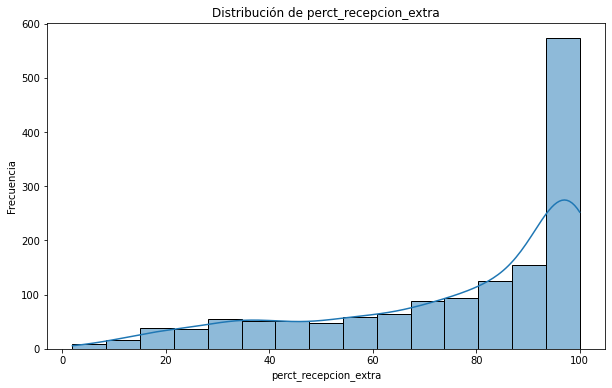

In [57]:
plot_histogram(df,'perct_recepcion_extra' )

- Se observa del grafico que las comunidades tienen una % de recepcion extra grupo con tendencia al 100%, lo que indica que la mayoria de comunidades recibe en casi todo el IVA desde afuera. Interesantes son los casos con este valor menor al 50% pues indicaria que mas de la mitad del IVA recibido viene del mismo grupo.

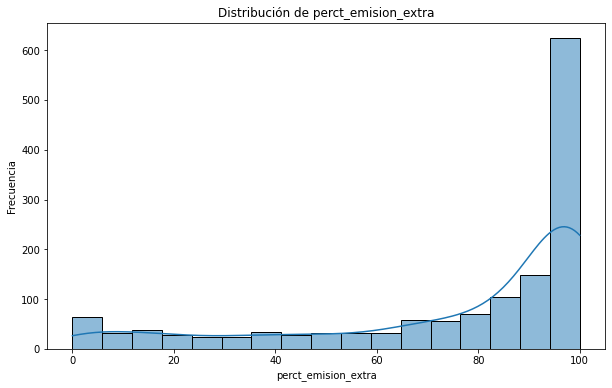

In [58]:
plot_histogram(df,'perct_emision_extra' )

- De forma similar, el grafico de porcentaje de emision extra grupo indica que la mayoria de las comunidades emite su IVA al exterior del grupo. Sin embargo hay comunidades donde la mayoria se emite hacia el mismo grupo.

Para las otras columnas, usaremos la tecnica IQR para visualizar los datos sin valores atipicos. 

In [59]:
def histograma_no_outliers(dataframe, column_name):
    """
    Genera un histograma de distribución para una columna dada de un DataFrame.

    Args:
    dataframe (pd.DataFrame): DataFrame que contiene la columna de interés.
    column_name (str): Nombre de la columna para la cual se generará el histograma.
    """
    
    # Filtrar los valores no nulos de la columna
    data = dataframe[column_name].dropna()
    
    # Calcular el rango intercuartílico (IQR)
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Definir los límites para considerar outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filtrar los valores dentro del rango de aceptación
    data_filtered = data[(data >= lower_bound) & (data <= upper_bound)]
    
    # Configurar el tamaño de la figura
    plt.figure(figsize=(10, 6))
    
    # Generar el histograma de distribución
    sns.histplot(data_filtered, kde=True)
    
    # Añadir títulos y etiquetas
    plt.title(f'Distribución de {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frecuencia')
    
    # Mostrar el histograma
    plt.show()

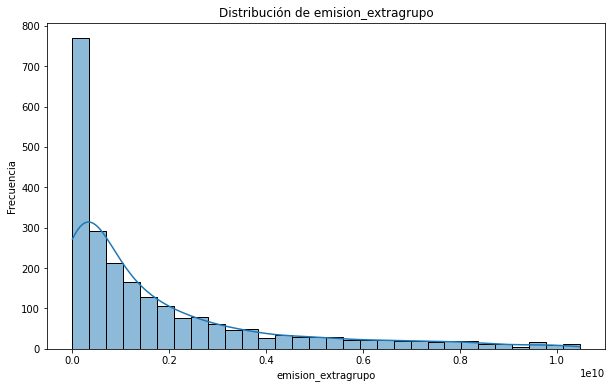

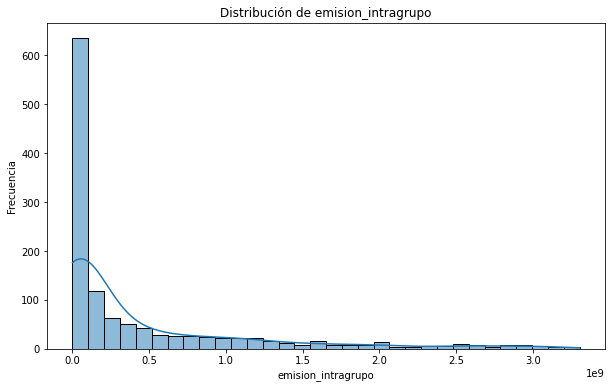

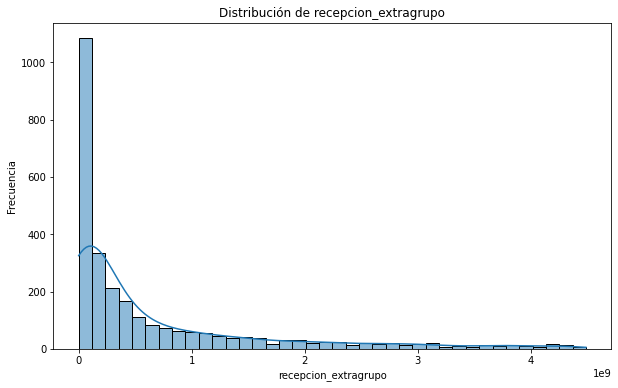

In [60]:
histograma_no_outliers(df,'emision_extragrupo' )
histograma_no_outliers(df,'emision_intragrupo' )
histograma_no_outliers(df,'recepcion_extragrupo' )

- En el primer grafico, luego de sacar los valores atipicos, observamos que la mayoria de los valores de emision extragrupo se encuentra bajo el valor 0.4e+10. 
- En el segundo grafico, para el caso de emision intragrupo, la mayoria de los valores esta bajo 1.5e+9.
- En el tercer grafico, en el caso de la recepcion extragrupo, se observa que la mayoria de valores se encuentra bajo 2e+9. Notese que la emision intragrupo equivale a la recepcion intra grupo.

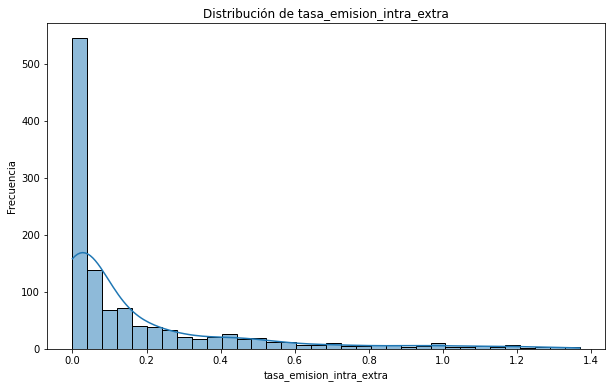

In [61]:
histograma_no_outliers(df,'tasa_emision_intra_extra')

Observemos que sin valores atipicos, obtenemos que la distribucion de tasa de emision intra y extra tiene tendencia a valores bajos (lo cual corresponde a que la mayoria del IVA se emite hacia afuera)

In [62]:
len(df[df['tasa_emision_intra_extra']>1])

282

Por lo cual existen 282 grupos donde la emision de IVA es mayor hacia adentro del grupo que hacia afuera.

A continuacion se guarda este set de datos en la carpeta correspondiente para su utilizacion posterior.

In [64]:
df.to_csv('/home/cdsw/data/processed/iva_grupos_economicos/iva_grupos_economicos.csv', index=False)